In [12]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

from cued_sf2_lab.familiarisation import load_mat_img, plot_image

# 12. Combined run-length / Huffman coding methods

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

Up to this point, we have been using entropy as a measure of the number of bits for the
compressed image.  Now we attempt to produce a vector of compressed image data
which accurately represents the compression that can be achieved in practise.

Huffman codes are relatively
efficient at coding data with non-uniform probability distributions, provided
that the probability of any single event does not exceed 50%.  However, when
an image is transformed by any of the energy compaction methods
considered so far, a high proportion of the quantised coefficients are zero,
so this event usually does have a probability much greater than 50%.  In fact
it is only when this _is_ a high probability event that high compression
can be achieved!  Therefore new ways of using Huffman codes have been
developed to deal with this situation as efficiently as possible.

## 12.1 Baseline JPEG coding techniques

The standard Huffman coding solution, used by the baseline JPEG
specification and most other image compression standards, is to code each
non-zero coefficient combined with the number of zero coefficients which
preceed it as a single event.

For example the sequence of coefficients:
$$
3, 0, 0, -2, 0, 0, 0, 1, 0, -3, -1, 0, 0, 0, 0, 1, \ldots
$$
would be coded as the following 6 events:
```
0 zeros, 3
2 zeros, -2
3 zeros, 1
1 zero, -3
0 zeros, -1
4 zeros, 1
```

Each event has a certain probability (usually well below 50%) and
can be coded efficiently with a standard Huffman code.  As
formulated above, the number of combinations of amplitude and
run-length can be very large, leading to a highly complex code.
JPEG limits this complexity to only 162 combinations by
restricting the maximum run-length to 15 zeros and by coding only
the base-2 logarithm of the amplitude in the Huffman code, rounded
up to integers from 1 to 10.  The sign bit and the remaining
amplitude bits are then appended to the Huffman code word.  16 run lengths (0 to
15) and 10 log amplitudes (1 to 10) give 160 of the code words.
The other two codewords are the end-of-block word (EOB),
signifying no more non-zero coefficients in the current block, and
the run-of-16 word (ZRL), which may be used repetitively ahead of
another codeword for runs of 16 or more zeros.

JPEG is based on $8 \times 8$ DCT transformations of the image, and the data
from each $8 \times 8$ block of DCT coefficients is coded as a block of
Huffman codewords.  First the dc coefficient (top left corner) is coded.
There is little penalty in using a fixed-length binary code for this, although
JPEG uses differential and Huffman coding for slightly improved performance.
Then the remaining 63 ac coefficients are arranged into a linear vector, by
scanning the $8 \times 8$ block in a zig-zag manner corresponding to
progressively increasing frequencies (see the JPEG standard, section 3, fig 5).  This places
the larger low-frequency coefficients close together near the start of the
vector (with short run lengths) and the smaller high-frequency coefficients
spread out towards the end of the vector (with long run lengths).  The
end-of-block word efficiently terminates the coding of each block after the
last non-zero coefficient.

For further details of the JPEG techniques, referred to above, see the JPEG
standard, sections 3.3 and 3.6 and appendices A.3, C, F.1.1, F.1.2, F.2.1,
F.2.2, K.1, K.2, and K.3.  Note that for this project we ignore the higher
layers of the JPEG specification, and do not align code segments with byte
boundaries or use two-byte marker codes to identify different data segments.
JPEG also permits arithmetic codes to be used instead of Huffman codes, but
these are more complicated so we recommend that you should use the latter.


## 12.2 Python implementation of Huffman coding

<div class="alert alert-warning alert-block">
    
This section is **very** incomplete!</div>


The file at `cued_sf2_lab/jpeg.py` contains implementations of the following functions:

* `jpegenc`: perform simplified JPEG encoding of an image `X` into a matrix of variable length codewords `vlc`.
* `jpegdec`: perform simplified JPEG decoding of a codeword matrix `vlc` into an image `Z`.
* `quant1`: quantise a matrix into integers representing the quantiser step numbers, which is the form necessary to allow Huffman coding.
* `quant2`: reconstruct a matrix from integers.  Together with `quant1` this is equivalent to `quantise`.
* `runampl`: convert a vector of coefficients `a` into a matrix of run-length, log-amplitude and signed-remainder values `rsa`.
* `huffenc`: convert a run/amplitude matrix `rsa` into a matrix of variable-length codewords `vlc`.
* `huffdflt`: generate the specification table `hufftab`, for the default JPEG Huffman code tables for AC luminance
or AC chrominance coefficients (JPEG specification, appendix K.3.3.2).
* `huffdes`: design the specification table, `hufftab`, for optimised JPEG Huffman code tables using a histogram of
codeword usage `huffhist`.
* `huffgen`: generate the Huffman code tables, `huffcode` and `ehuf`, from `hufftab`.

In [13]:
from cued_sf2_lab.jpeg import (
    jpegenc, jpegdec, quant1, quant2, huffenc, huffdflt, huffdes, huffgen)

In order to allow relatively fast decoding in Python, we have cheated a
little in the format of the coded data.  Each variable-length codeword is
stored as an integer element of the required word length in the first column
of a 2-column matrix `vlc` and the length of the codeword in bits is
stored next to it in the second column.  We do not bother to pack this data
into a serial bit stream since it is awkward and time consuming to unpack in
Matlab, and we have not got around to changing this now that the lab is in Python!
The length of the bit-stream if it were packed can easily be obtained
from `vlc[:,1].sum()`.

To perform the simplified JPEG encoding, based on the $8 \times 8$ DCT,
load the image in `X` and type:  `vlc, hufftab = jpegenc(X, qstep)`.
You can inspect the codewords with `dict(zip(hufftab.huffval, hufftab.codes))`.

In [14]:
# your code here
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')
qstep = 17
vlc, hufftab = jpegenc(X, qstep)
vlc2 = jpegenc(bridge, qstep)[0]
vlc3 = jpegenc(flamingo, qstep)[0]

Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Bits for coded image = 67607
Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Bits for coded image = 102238
Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Bits for coded image = 88863


This produces variable-length coded data in `vlc`, using quantisation step sizes of qstep.  To decode `vlc`, type:  `Z = jpegdec(vlc, qstep)`

Generating huffcode and ehuf using default tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

Generating huffcode and ehuf using default tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

Generating huffcode and ehuf using default tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

The RMS error for huffman coding for a lighthouse is:5.262524463981773
The RMS error for huffman coding for a flamingo is:6.128764422688171
The RMS error for huffman coding for a bridge is:7.031060167745797
The compression ratio for huffman coding for a lighthouse is:3.1473220228674545
The compression ratio for huffman coding for a flamingo is:2.502863959128096
The compression ratio for huffman coding for a bridge is:2.1616424421447995


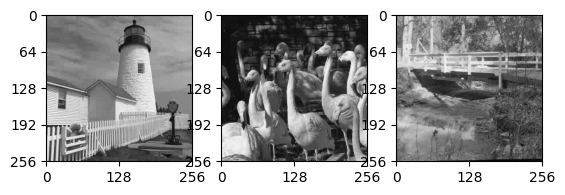

In [15]:
# your code here
Z = jpegdec(vlc, qstep)
Z2 = jpegdec(vlc2, qstep)
Z3 = jpegdec(vlc3, qstep)
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
plot_image(Z, ax=ax1)
plot_image(Z3, ax=ax2)
plot_image(Z2, ax=ax3)

print("The RMS error for huffman coding for a lighthouse is:" + str(np.std(X-Z)))
print("The RMS error for huffman coding for a flamingo is:" + str(np.std(flamingo-Z3)))
print("The RMS error for huffman coding for a bridge is:" + str(np.std(bridge-Z2)))

print("The compression ratio for huffman coding for a lighthouse is:" + str(212781/67607))
print("The compression ratio for huffman coding for a flamingo is:" + str(222412/88863))
print("The compression ratio for huffman coding for a bridge is:" + str(221002/102238))

This `jpeg.py` file is given to you as examples of how to achieve a complete compression
system. They have other options and outputs, and in general you will need to copy them to a new
file and modify them to perform your own algorithms.

In `jpegenc`, there are two ways to specify the Huffman
tables: either the default JPEG AC luminance or chrominance tables
may be used; or custom tables may be designed, based on statistics
in the histogram vector `huffhist`. To generate a valid
histogram for `huffdes`, coding must be performed at least
once using `huffdflt` instead, so `jpegenc` is written
such that the default tables are used first and then, if required,
the code is redesigned using custom tables. Note that if it is
planned to use `huffdes` to generate an optimised Huffman code
for each new image to be coded, then the specification tables `hufftab.bits` and `hufftab.huffval` must be sent with the compressed image,
which costs (16 + 162) bytes = 1424 bits.  You should consider
whether or not this is a sensible strategy.

## Going beyond JPEG and the DCT

If you have chosen the DCT as one of your energy compaction
methods then it is fairly straightforward to follow the JPEG
guidelines for coding the coefficients.  However if you have
chosen one of the other methods then a modified scanning strategy is required.

It has already been mentioned that the LBT (which is at the heart of the JPEG-XR standard) is often coded several sub-blocks at a time. We can make a smaller LBT ($4 \times 4$ is the default) look like a $16 \times 16$ DCT by using the `regroup(Yq, 4)` function within each $16 \times 16$ block of `Yq`. The functions `jpegenc` and `jpegdec` have already been written to do this if the `M` argument (which specifies the {\em coding} block size) is larger than the `N` argument (which specifies the DCT block size).

The DWT (which is the basis of the JPEG2000 standard) can also be re-arranged to make it look similar to a DCT. For instance, a 3-level DWT could be re-arranged into an $8 \times 8$ block $B$ using coefficients from the same
square spatial area:


> 4 values from level 3: $B3$ = [$UU_3$ $VU_3$; $UV_3$, $VV_3$]  
> 3 surrounding $2 \times 2$ blocks from level 2: $B2$ = [$B3$ $VU_2$; $UV_2$ $VV_2$]  
> 3 surrounding $4 \times 4$ blocks from level 1: $B$ = [$B2$ $VU_1$; $UV_1$ $VV_1$]

It is not possible to achieve this sort of grouping using the simple `regroup` function, so we have provided a more complicated function 
`dwtgroup(X,n)` which converts an n-level DWT sub-image set into blocks of size $N \times N$ (where $N = 2^n$) with the above type of grouping.  Try this
function on some small regular matrices (e.g. `np.arange(16*16).reshape(16, 16)`) to
see how it works. Note that `dwtgroup(X, -n)` reverses this grouping.

In [16]:
from cued_sf2_lab.jpeg import dwtgroup
# this is a nice trick to get an array of coordinates; use `display(x)` to check what this is doing
# i, j = np.indices((8, 8))
# x = np.rec.array((i, j))
# print(dwtgroup(x, 2))

vlc_lbt_lighthouse, hufftabopt1 = jpegenc(X, 17, 8, 16, True)
vlc_lbt_flamingo, hufftabopt2 = jpegenc(flamingo, 17, 8, 16, True)
vlc_lbt_bridge, hufftabopt3 = jpegenc(bridge, 17, 8, 16, True)

Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 69481
Bits for huffman table = 1424
Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 92942
Bits for huffman table = 1424
Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 101306
Bits for huffman table = 1424


In [17]:
Z_lbt_lighthouse = jpegdec(vlc_lbt_lighthouse, 17, 8, 16, hufftabopt1)
Z_lbt_flamingo = jpegdec(vlc_lbt_flamingo, 17, 8, 16, hufftabopt2)
Z_lbt_bridge = jpegdec(vlc_lbt_bridge, 17, 8, 16, hufftabopt3)

Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT



The RMS error for huffman coding for a lighthouse is:5.262524463981773
The RMS error for huffman coding for a flamingo is:6.128764422688171
The RMS error for huffman coding for a bridge is:7.031060167745797
The compression ratio for huffman coding for a lighthouse is:3.000930822932092
The compression ratio for huffman coding for a flamingo is:2.356908208464913
The compression ratio for huffman coding for a bridge is:2.15128978876667


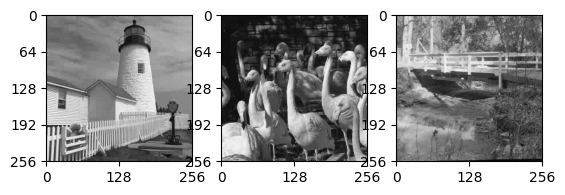

In [18]:
fig, (ax4,ax5,ax6) = plt.subplots(1,3)
plot_image(Z_lbt_lighthouse, ax=ax4)
plot_image(Z_lbt_flamingo, ax=ax5)
plot_image(Z_lbt_bridge, ax=ax6)

print("The RMS error for huffman coding for a lighthouse is:" + str(np.std(X-Z_lbt_lighthouse)))
print("The RMS error for huffman coding for a flamingo is:" + str(np.std(flamingo-Z_lbt_flamingo)))
print("The RMS error for huffman coding for a bridge is:" + str(np.std(bridge-Z_lbt_bridge)))

print("The compression ratio for huffman coding for a lighthouse is:" + str(212781/(69481+1424)))
print("The compression ratio for huffman coding for a flamingo is:" + str(222412/(92942+1424)))
print("The compression ratio for huffman coding for a bridge is:" + str(221002/(101306+1424)))

In [19]:
X_r = dwtgroup(X,4)
flamingo_r = dwtgroup(flamingo,4)
bridge_r = dwtgroup(bridge,4)
vlc_dwt_lighthouse, hufftabdwtopt1 = jpegenc(X_r, 17, 8, 16, True)
vlc_dwt_flamingo, hufftabdwtopt2 = jpegenc(flamingo_r, 17, 8, 16, True)
vlc_dwt_bridge, hufftabdwtopt3 = jpegenc(bridge_r, 17, 8, 16, True)

Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 82951
Bits for huffman table = 1424
Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 115049
Bits for huffman table = 1424
Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 127454
Bits for huffman table = 1424


In [20]:
Z_dwt_lighthouse = jpegdec(vlc_dwt_lighthouse, 17, 8, 16, hufftabdwtopt1)
Z_dwt_flamingo = jpegdec(vlc_dwt_flamingo, 17, 8, 16, hufftabdwtopt2)
Z_dwt_bridge = jpegdec(vlc_dwt_bridge, 17, 8, 16, hufftabdwtopt3)

Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT



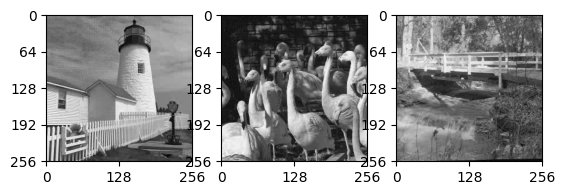

In [21]:
fig, (ax7,ax8,ax9) = plt.subplots(1,3)
plot_image(dwtgroup(Z_dwt_lighthouse,-4), ax=ax7)
plot_image(dwtgroup(Z_dwt_flamingo,-4), ax=ax8)
plot_image(dwtgroup(Z_dwt_bridge,-4), ax=ax9)

In [22]:
print("The RMS error for huffman coding for a lighthouse using dwt is:" + str(np.std(X-dwtgroup(Z_dwt_lighthouse,-4))))
print("The RMS error for huffman coding for a flamingo using dwt is:" + str(np.std(flamingo-dwtgroup(Z_dwt_flamingo,-4))))
print("The RMS error for huffman coding for a bridge using dwt is:" + str(np.std(bridge-dwtgroup(Z_dwt_bridge,-4))))

print("The compression ratio for huffman coding for a lighthouse is:" + str(212781/(82951+1424)))
print("The compression ratio for huffman coding for a flamingo is:" + str(222412/(115049+1424)))
print("The compression ratio for huffman coding for a bridge is:" + str(221002/(127454+1424)))

The RMS error for huffman coding for a lighthouse using dwt is:5.767329720355873
The RMS error for huffman coding for a flamingo using dwt is:6.485107609891932
The RMS error for huffman coding for a bridge using dwt is:7.084677924190997
The compression ratio for huffman coding for a lighthouse is:2.521848888888889
The compression ratio for huffman coding for a flamingo is:1.9095584384363757
The compression ratio for huffman coding for a bridge is:1.7148155620043761



With these modified scanning strategies, the JPEG run-length / log amplitude coding can then be used for each vector in the same way as for the DCT coefficients. However, these scanning strategies are not optimal, and do not represent those outlined in the JPEG2000 and JPEG-XR standards.

You should write versions of `jpegenc` and `jpegdec` for
your chosen compression strategies and check the following:
1. The rms error (standard deviation) between the decoded and original
images should be the same as for the equivalent quantisation
strategies that were tested in the previous section on
centre-clipped linear quantisers.  No extra errors should be
introduced by the scanning or Huffman encode / decode operations.

2. The number of bits required to code an image should be comparable with
the value predicted from the entropy of the quantised coefficients (i.e.
within about 20%).  Note that it is possible to code with fewer bits than
predicted by the entropy because the run-length coding can take advantage of
clustering of non-zero coefficients, which is not taken account of in the
first-order entropy calculations.

